In [1]:
import pymust, tqdm
import numpy as np, matplotlib.pyplot as plt

# A QUICK START DEMO - simulations, demodulation, beamforming, compounding

In this quick'n easy tutorial, it is shown how to simulate an ultrasound image from the transmit of plane waves. A few scatterers will be insonified with steered planes waves to obtain a compound image. You will use the following fundamental steps:

 1.   A transducer will be chosen with GETPARAM,
1. Transmit delays will be designed with TXDELAY
1.    A pressure field will be calculated with PFIELD
1.   RF signals will be simulated with the function SIMUS.
1.   The RF signals will be I/Q demodulated with RF2IQ,
1.    then beamformed with DAS.
1.    A compound image will eventually be generated.

## Scatterers
Define a few scatterers with their reflective coefficients

In [2]:
xs = np.array([1.7, 1.3, 0.7, 0, -0.7, -1.3, -1.7, 0, -1, 1])*1e-2;  # in m
zs = np.array([2.8, 3.2, 3.5, 3.6, 3.5, 3.2, 2.8, 2, 0.8, 0.8])*1e-2 # in m
RC = np.ones(xs.shape)

## Select a transducer with GETPARAM

We want a 128-element linear array.

In [3]:
param = pymust.getparam('L11-5v')

The structure param contains the tranducer properties.

## Design the transmit delays with TXDELAY

The scatterers will be insonified with 21 plane waves steered at -10 to +10 degrees. Use TXDELAY to calculate the transmit delays for the 21 plane waves.


In [4]:
tilt = np.linspace(-10,10,21)/180*np.pi; # tilt angles in rad
txdel = []
for t in tilt:
    txdel.append(pymust.txdelay(param, t))
txdel = np.array(txdel)

# Check a pressure field with PFIELD

Let us visualize the 5th pressure field.

Define a 100 $\times$ 100 8-cm-by-8-cm grid.

In [5]:
x_extent = np.linspace(-4e-2,4e-2,100)
y_extent = np.linspace(0,8e-2,100)
xi,zi = np.meshgrid(x_extent, y_extent);

We will consider elevation focusing. We thus also need y-coordinates to force the use of the 3-D acoustic equations. Here, they are all 0.

In [6]:
yi = np.zeros(xi.shape)

Simulate the pressure field.


In [7]:
P, _, _ = pymust.pfield(xi,yi,zi,txdel[4],param);


Display the 5th pressure field.

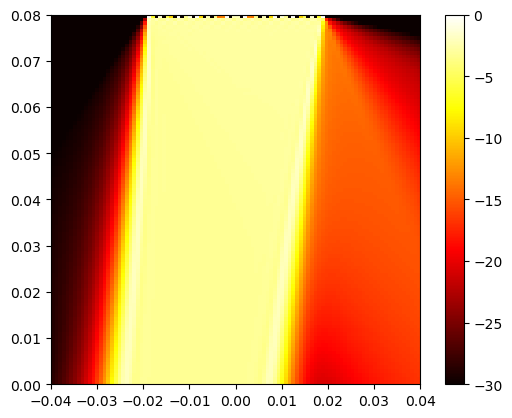

In [8]:
plt.imshow(20 * np.log10(P / np.max(P)), cmap='hot', extent=[xi[0,0], xi[0, -1], zi[0,0], zi[-1, -1]])
plt.colorbar()
plt.clim(-30, 0)

# Simulate RF signals with SIMUS

We will now simulate 21 series of RF signals. Each series will contain 128 RF signals, as the simulated linear array contains 128 elements.

In [9]:
RF = [] # this array will contain the RF series
param.fs = 4*param.fc; # sampling frequency in Hz
for k,t in tqdm.tqdm(enumerate(txdel)):
    r, _ = pymust.simus(xs,zs,RC,t, param)
    RF.append(r)


0it [00:00, ?it/s]

21it [00:01, 20.62it/s]


This is the 64th RF signal of the 1st series:

Text(0.5, 1.0, 'RF signal of the $64^{th}$ element ($1^{st}$ series, tilt = $-20{\\circ}$)')

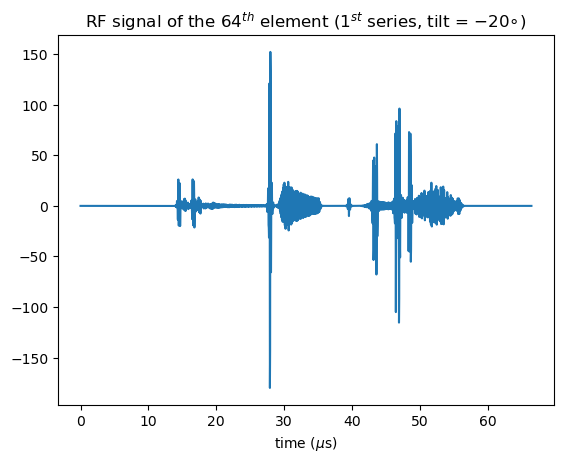

In [10]:
rf = RF[0][:,63]
t = np.arange(len(rf))/param.fs*1e6 #% time (ms)
plt.plot(t,rf)
plt.xlabel('time ($\mu$s)')
plt.title('RF signal of the $64^{th}$ element ($1^{st}$ series, tilt = $-20{\circ}$)')


## Demodulate the RF signals with RF2IQ

Before beamforming, the RF signals must be I/Q demodulated.

In [11]:
IQ = [] #  % this cell will contain the I/Q series

for r in RF:
    IQ.append(pymust.rf2iq(r,param.fs,param.fc))


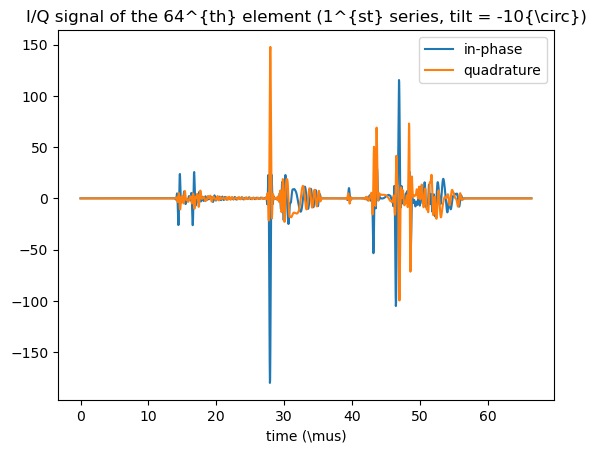

In [12]:
iq = IQ[0][:,63];
plt.plot(t,np.real(iq), label = 'in-phase')
plt.plot(t,np.imag(iq), label = 'quadrature')
plt.xlabel('time (\mus)')
plt.title('I/Q signal of the 64^{th} element (1^{st} series, tilt = -10{\circ})')
plt.legend()


## Beamform the I/Q signals with DAS

It is recommended to use an adequate receive f-number when beamforming. Define a void f-number; it will be determined automatically by DAS from the element directivity.

In [13]:
param.fnumber = None

Define a 200 $\times$ 200 4-cm-by-4-cm image grid.

In [14]:
x_extent = np.linspace(-2e-2,2e-2,200)
z_extent = np.linspace(0,4e-2,200)
xi,zi = np.meshgrid(x_extent, z_extent)

In [15]:
t

array([0.00000000e+00, 3.28947368e-02, 6.57894737e-02, ...,
       6.63486842e+01, 6.63815789e+01, 6.64144737e+01])

In [16]:
p = param.copy()


In [23]:
pymust.dasmtx(IQ[k], xi,zi, p)

<1x258560 sparse matrix of type '<class 'numpy.complex128'>'
	with 0 stored elements in COOrdinate format>

In [18]:
bIQ = np.zeros((*xi.shape, len(txdel)), dtype = np.complex64)  #% this array will contain the 21 I/Q images

for k, t in enumerate(txdel):
    param.TXdelay = t
    q = (pymust.dasmtx(IQ[k], xi,zi, param) @ IQ[k].flatten(order = 'F')).reshape(xi.shape,order = 'F')
    bIQ[:,:,k] = q


## Compound ultrasound image

An ultrasound image is obtained by log-compressing the amplitude of the beamformed I/Q signals. Have a look at the images obtained when steering at -10 degrees.

/Users/gbernardino/pymust/src/pymust/bmode.py:59: RuntimeWarning: invalid value encountered in divide
  I = 20*np.log10(I/np.max(I))+DR
/Users/gbernardino/pymust/src/pymust/bmode.py:63: RuntimeWarning: invalid value encountered in cast
  return I.astype(np.uint8)


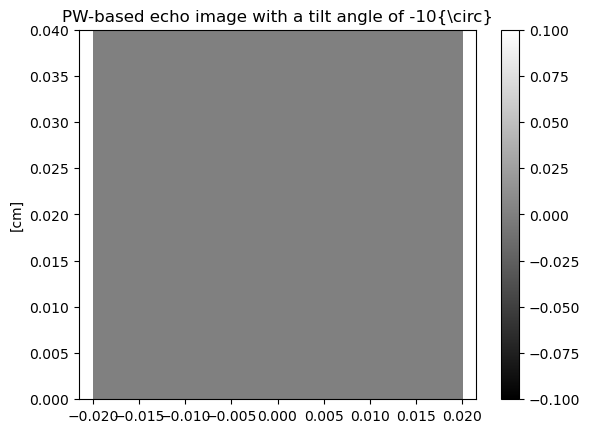

In [19]:
I = pymust.bmode(bIQ[:,:,0],40) # log-compressed image
plt.imshow(I, cmap = 'gray', extent = [xi[0,0], xi[0,-1], zi[0,0], zi[-1,-1]])
plt.title('PW-based echo image with a tilt angle of -10{\circ}')
plt.axis('equal')
plt.ylabel('[cm]')
plt.colorbar()


The individual images are of poor quality. Generate a compound image with the series of 21 diverging waves steered at different angles.

Text(0.5, 1.0, 'Compound PW-based echo image')

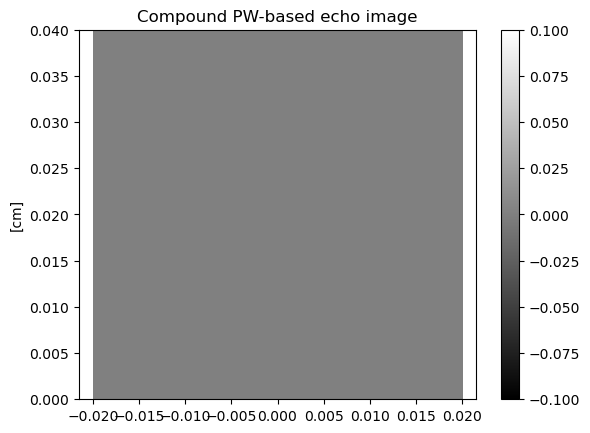

In [20]:
cIQ = np.sum(bIQ,2) # this is the compound beamformed I/Q
I = pymust.bmode(cIQ,40); #log-compressed image
plt.imshow(I, cmap = 'gray', extent = [xi[0,0], xi[0,-1], zi[0,0], zi[-1,-1]])
plt.colorbar()
#plt.clim(-40,0)
plt.axis('equal')
plt.ylabel('[cm]')
plt.title('Compound PW-based echo image')


# MKmovie

In [21]:
param.attenuation = 0.0
F,info, param = pymust.mkmovie(xs, zs, RC, txdel,param, 'noAttenuation.gif');

AttributeError: 'str' object has no attribute 'ignoreCaseInFieldNames'

In [ ]:
param.attenuation = 0.5
F,info, param = pymust.mkmovie(xs, zs, RC, txdel,param, 'noAttenuation.gif');